<a href="https://colab.research.google.com/github/Pager07/FinalYearProject/blob/master/CourtSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project LadderBoard
- Imports (DONE)
- Viewing Data (DONE)
  - Images (DONE)
  - Mask (DONE)
- Load codes files (DONE)
- Write function to load the mask (DONE)
- Create DataSet 
- Create Dataloader 
- Create Model
  - 

#Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from google.colab import drive

In [16]:
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


#Understanding the data

In [0]:
root_dir =  '/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4'
path = Path(root_dir)

In [0]:
path_lbl = path/'Labels'
path_img = path/'Image'

In [19]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-6 screenshot.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-11 screenshot.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Image/LeBron James Efficiently Layups 2015-16 Regular Season 5-23 screenshot.png')]

In [20]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-6 screenshot_mask.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-7 screenshot_mask.png'),
 PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data4/Labels/LeBron James Efficiently Layups 2015-16 Regular Season 5-7 screenshot (1)_mask.png')]

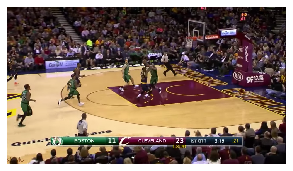

In [21]:
img_f  = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask{x.suffix}'

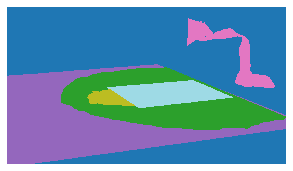

In [27]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5) , alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[0, 0, 2,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 2, 2,  ..., 0, 0, 0],
          [0, 2, 2,  ..., 0, 0, 0],
          [0, 2, 2,  ..., 0, 0, 0]]]))

In [24]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Other', '2Point', '3Point', 'Board', 'Freethrow', 'Layup'], dtype='<U9')

#Creating DataObject,Dataloader and Databunch

In [25]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)
class MySegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

NameError: ignored

In [12]:
src_size // 4

array([180, 320])

In [28]:
size = src_size
free  = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free") 

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.3)
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms() , size= 244, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

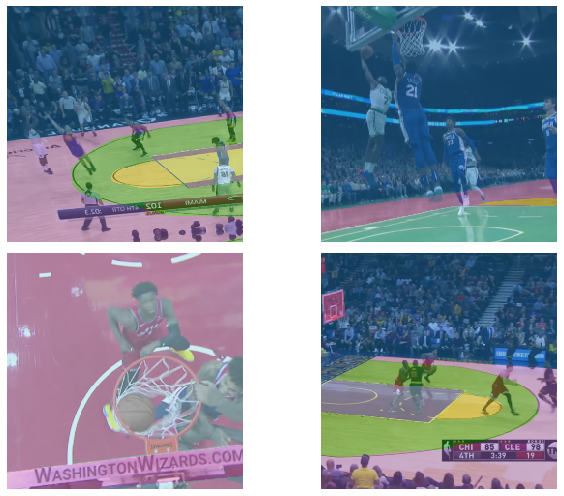

In [14]:
data.show_batch(2,figsize=(10,7))

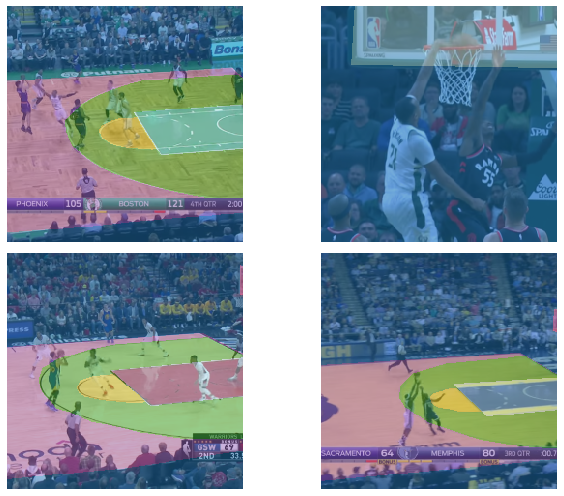

In [15]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

#Building the model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Other']

def acc_courtSeg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# def dice(pred, targs):
#    pred = (pred>0).float()
#    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [0]:
metrics = acc_courtSeg

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_courtseg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


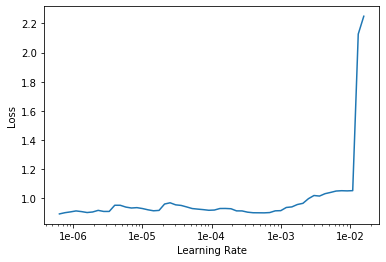

In [35]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-4

In [43]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_courtSeg,time
0,1.065944,0.997166,0.379286,00:26
1,0.826907,1.136261,0.243971,00:26
2,0.706280,0.736506,0.567766,00:26
3,0.651170,0.798317,0.454266,00:26
4,0.644594,0.622198,0.605913,00:26
5,0.588684,0.533103,0.651765,00:26
6,0.575567,0.601424,0.574684,00:26
7,0.490504,0.551573,0.747488,00:26
8,0.471022,0.597348,0.681400,00:26
9,0.301472,0.407467,0.803063,00:27


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

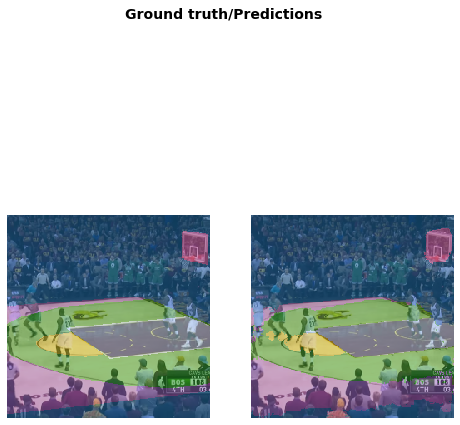

In [47]:
learn.show_results(rows=3, figsize=(8,9))